# Train Vanilla Transformer from Scratch

Now that we understand how Transformer works, let's code a sequence to sequence model which shall generate `python code` when fed with `comments`. In future you may never ever write a complete transformer architecture from scratch, that's why having such exercise once in a lifetime is necessary!

The differences between the implementation in this notebook and the original[paper](https://arxiv.org/abs/1706.03762) are:

- we use a learned positional encoding instead of a static one
- we use the standard Adam optimizer with a static learning rate instead of one with warm-up and cool-down steps
- we do not use label smoothing

We make all of these changes as they closely follow one of the most popular Transformer variant - BERT (Bidirectional Encoder Representations from Transformers) set-up and the majority of Transformer variants use a similar set-up.

Note: This notebook is heavily influenced from [bentrevett's notebook](http://nbviewer.org/github/bentrevett/pytorch-seq2seq/blob/master/6%20-%20Attention%20is%20All%20You%20Need.ipynb). 

Steps Covered:
1. Import Libraries
2. Data Preparation (with custom tokenizer)
3. Transformer Archtitecture from Scratch
4. Model Building
5. Model Training
6. Model Evaluation
7. Sample Outputs
8. Gradio App



## Import Libraries

In [1]:
#!pip install -U torch==1.8.0 torchtext==0.9.0

In [ ]:
#!pip install -q gradio

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchtext
from torchtext.legacy.data import Field, BucketIterator, Iterator
from torchtext.legacy import data
from torchtext.data.metrics import bleu_score

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np
import pandas as pd

import io
import random
import math
import time
import keyword
from tokenize import tokenize, untokenize
from pprint import pprint
from tqdm.notebook import tqdm
import gradio as gr

In [3]:
print(f"Torch: {torch.__version__}")
print(f"Torchtext: {torchtext.__version__}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Torch: 1.8.0
Torchtext: 0.9.0
Device: cuda


In [4]:
SEED = 101
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Data Preparation

Let's import the data file

In [5]:
f = open("english_python_data.txt", "r")
file_lines = f.readlines()
file_lines[:20]

['# write a python program to add two numbers \n',
 'num1 = 1.5\n',
 'num2 = 6.3\n',
 'sum = num1 + num2\n',
 "print(f'Sum: {sum}')\n",
 '\n',
 '\n',
 '# write a python function to add two user provided numbers and return the sum\n',
 'def add_two_numbers(num1, num2):\n',
 '    sum = num1 + num2\n',
 '    return sum\n',
 '\n',
 '\n',
 '# write a program to find and print the largest among three numbers\n',
 '\n',
 'num1 = 10\n',
 'num2 = 12\n',
 'num3 = 14\n',
 'if (num1 >= num2) and (num1 >= num3):\n',
 '   largest = num1\n']

Our dataset is formulated in a manner where every question starts with '#'. 

Lines between two consecutive '#' forms the solution to the question.



In [6]:
dps = []
dp = None
for line in file_lines:
  if line[0] == "#":
    if dp:
      dp['solution'] = ''.join(dp['solution'])
      dps.append(dp)
    dp = {"question": None, "solution": []}
    dp['question'] = line[1:]
  else:
    dp["solution"].append(line)

Lets take a look at the first 4 entries of the data we have parsed.

In [7]:
i=0
for dp in dps:
  print("\n Question no: ", i+1)
  i+=1
  print(dp['question'][1:])
  print(dp['solution'])
  if i>3:
    break


 Question no:  1
write a python program to add two numbers 

num1 = 1.5
num2 = 6.3
sum = num1 + num2
print(f'Sum: {sum}')




 Question no:  2
write a python function to add two user provided numbers and return the sum

def add_two_numbers(num1, num2):
    sum = num1 + num2
    return sum




 Question no:  3
write a program to find and print the largest among three numbers


num1 = 10
num2 = 12
num3 = 14
if (num1 >= num2) and (num1 >= num3):
   largest = num1
elif (num2 >= num1) and (num2 >= num3):
   largest = num2
else:
   largest = num3
print(f'largest:{largest}')




 Question no:  4
write a program to find and print the smallest among three numbers

num1 = 10
num2 = 12
num3 = 14
if (num1 <= num2) and (num1 <= num3):
   smallest = num1
elif (num2 <= num1) and (num2 <= num3):
   smallest = num2
else:
   smallest = num3
print(f'smallest:{smallest}')





In [8]:
print("Dataset size:", len(dps))

Dataset size: 4957


### Using a custom tokenizer to tokenize python code
Python is a programming language with its own unique syntax. Regular tokenizers like spacy are meant to tokenize english sentences and are not optimized towards Python's syntax. Here, we write our own custom tokenizer that makes use of Python's default tokenize library. When we make use of this library we only extract the token type and the token string.

In [9]:
def tokenize_python_code(python_code_str):
    python_tokens = list(tokenize(io.BytesIO(python_code_str.encode('utf-8')).readline))
    tokenized_output = []
    for i in range(0, len(python_tokens)):
        tokenized_output.append((python_tokens[i].type, python_tokens[i].string))
    return tokenized_output

In [10]:
tokenized_sample = tokenize_python_code(dps[1]['solution'])
pprint(tokenized_sample)

[(57, 'utf-8'),
 (1, 'def'),
 (1, 'add_two_numbers'),
 (53, '('),
 (1, 'num1'),
 (53, ','),
 (1, 'num2'),
 (53, ')'),
 (53, ':'),
 (4, '\n'),
 (5, '    '),
 (1, 'sum'),
 (53, '='),
 (1, 'num1'),
 (53, '+'),
 (1, 'num2'),
 (4, '\n'),
 (1, 'return'),
 (1, 'sum'),
 (4, '\n'),
 (56, '\n'),
 (56, '\n'),
 (6, ''),
 (0, '')]


In [11]:
print(untokenize(tokenized_sample).decode('utf-8'))

def add_two_numbers (num1 ,num2 ):
    sum =num1 +num2 
    return sum 





Since we have mere 5000 data points, we make use of data augmentations to increase the size of our dataset. While tokenizing the python code, we mask the names of certain variables randomly (with 'var_1, 'var_2' etc) to ensure that the model that we train does not merly fixate on the way the variables are named and actually tries to understand the inhrent logic and syntax of the python code.

But, while randomly picking varibles to mask we avoid keyword literals(keyword.kwlist), control structures(as can be seen in below skip_list) and object properties. We add all such literals that need to be skipped into the skip_list

`skip_list = ['range', 'enumerate', 'print', 'ord', 'int', 'float', 'char', 'list', 'dict', 'tuple', 'set', 'len', 'sum', 'min', 'max']`

In [12]:
def augment_tokenize_python_code(python_code_str):

    var_dict = {} # Dictionary that stores masked variables
    mask_factor=0.3

    # certain reserved words that should not be treated as normal variables and
    # hence need to be skipped from our variable mask augmentations
    skip_list = ['range', 'enumerate', 'print', 'ord', 'int', 'float', 'zip'
                 'char', 'list', 'dict', 'tuple', 'set', 'len', 'sum', 'min', 'max']
    # print(keyword.kwlist)
    skip_list.extend(keyword.kwlist)

    var_counter = 1
    python_tokens = list(tokenize(io.BytesIO(python_code_str.encode('utf-8')).readline))
    tokenized_output = []

    for i in range(0, len(python_tokens)):
        if python_tokens[i].type == 1 and python_tokens[i].string not in skip_list:
            if i>0 and python_tokens[i-1].string in ['def', '.', 'import', 'raise', 'except', 'class']: 
                # avoid masking modules, functions and error literals
                skip_list.append(python_tokens[i].string)
                tokenized_output.append((python_tokens[i].type, python_tokens[i].string))
            elif python_tokens[i].string in var_dict:
                # if variable is already masked
                tokenized_output.append((python_tokens[i].type, var_dict[python_tokens[i].string]))
            elif random.uniform(0, 1) > 1-mask_factor:
                # randomly mask variables
                var_dict[python_tokens[i].string] = 'var_' + str(var_counter)
                var_counter+=1
                tokenized_output.append((python_tokens[i].type, var_dict[python_tokens[i].string]))
            else:
                skip_list.append(python_tokens[i].string)
                tokenized_output.append((python_tokens[i].type, python_tokens[i].string))
      
        else:
            tokenized_output.append((python_tokens[i].type, python_tokens[i].string))
    
    return tokenized_output

In [13]:
tokenized_sample = augment_tokenize_python_code(dps[1]['solution'])
pprint(tokenized_sample)

[(57, 'utf-8'),
 (1, 'def'),
 (1, 'add_two_numbers'),
 (53, '('),
 (1, 'num1'),
 (53, ','),
 (1, 'num2'),
 (53, ')'),
 (53, ':'),
 (4, '\n'),
 (5, '    '),
 (1, 'sum'),
 (53, '='),
 (1, 'num1'),
 (53, '+'),
 (1, 'num2'),
 (4, '\n'),
 (1, 'return'),
 (1, 'sum'),
 (4, '\n'),
 (56, '\n'),
 (56, '\n'),
 (6, ''),
 (0, '')]


In [14]:
print(untokenize(tokenized_sample).decode('utf-8'))

def add_two_numbers (num1 ,num2 ):
    sum =num1 +num2 
    return sum 





As one can see our augmented tokenizer picked num2 randomly and masked(replaced) it with by var_1

### Create Train and Validation Dataset

In [15]:
python_problems_df = pd.DataFrame(dps)
python_problems_df.head()

,question,solution
0,write a python program to add two numbers \n,num1 = 1.5\nnum2 = 6.3\nsum = num1 + num2\npri...
1,write a python function to add two user provi...,"def add_two_numbers(num1, num2):\n sum = nu..."
2,write a program to find and print the largest...,\nnum1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 >=...
3,write a program to find and print the smalles...,num1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 <= n...
4,Write a python function to merge two given li...,"def merge_lists(l1, l2):\n return l1 + l2\n..."


In [16]:
# Splitting data into 85% train and 15% validation
msk = np.random.rand(len(python_problems_df)) < 0.85 

train_df = python_problems_df[msk]
val_df = python_problems_df[~msk]

In [17]:
print(train_df.shape)

(4194, 2)


### Creating vocabulary using torchtext
In this section we will use torchtext Fields to construct the vocabulary for our sequence-to-sequence learning problem.



In [18]:
Input = data.Field(tokenize = 'spacy',
            init_token='<sos>', 
            eos_token='<eos>', 
            lower=True)

Output = data.Field(tokenize = augment_tokenize_python_code,
                    init_token='<sos>', 
                    eos_token='<eos>', 
                    lower=False)

In [19]:
fields = [('Input', Input),('Output', Output)]

Since our data augmentations have the potential to increase the vocabulary beyond what it initially is, we must ensure that we capture as many variations as possible in the vocabulary that we develop. In the the below code we apply our data augmentations 50 times to ensure that we can capture a majority of augmentations into our vocabulary.

In [20]:
train_example = []
val_example = []

train_expansion_factor = 50
for j in range(train_expansion_factor):
    for i in range(train_df.shape[0]):
        try:
            ex = data.Example.fromlist([train_df.question[i], train_df.solution[i]], fields)
            train_example.append(ex)
        except:
            pass

for i in range(val_df.shape[0]):
    try:
        ex = data.Example.fromlist([val_df.question[i], val_df.solution[i]], fields)
        val_example.append(ex)
    except:
        pass

In [21]:
train_data = data.Dataset(train_example, fields)
valid_data =  data.Dataset(val_example, fields)

In [22]:
Input.build_vocab(train_data, min_freq = 0)
Output.build_vocab(train_data, min_freq = 0)

In [23]:
def save_vocab(vocab, path):
    import pickle
    output = open(path, 'wb')
    pickle.dump(vocab, output)
    output.close()

save_vocab(Input.vocab, "/content/src_vocab.pkl")
save_vocab(Output.vocab, "/content/trg_vocab.pkl")

In [24]:
pprint(vars(train_data.examples[0]))

{'Input': [' ',
           'write',
           'a',
           'python',
           'program',
           'to',
           'add',
           'two',
           'numbers'],
 'Output': [(57, 'utf-8'),
            (1, 'var_1'),
            (53, '='),
            (2, '1.5'),
            (4, '\n'),
            (1, 'var_2'),
            (53, '='),
            (2, '6.3'),
            (4, '\n'),
            (1, 'sum'),
            (53, '='),
            (1, 'var_1'),
            (53, '+'),
            (1, 'var_2'),
            (4, '\n'),
            (1, 'print'),
            (53, '('),
            (3, "f'Sum: {sum}'"),
            (53, ')'),
            (4, ''),
            (0, '')]}


In [25]:
BATCH_SIZE = 16
train_iterator, valid_iterator = BucketIterator.splits((train_data, valid_data), batch_size = BATCH_SIZE, 
                                                        sort_key = lambda x: len(x.Input),
                                                        sort_within_batch=True, device = device)

## Transformer Architecture from Scratch
Our transformer can be understood in terms of its three components:

- An Encoder that encodes an input sequence into state representation vectors.
- An Attention mechanism that enables our Transformer model to focus on the right aspects of the sequential input stream. This is used repeatedly within both the encoder and the decoder to help them contextualize the input data.
- A Decoder that decodes the state representation vector to generate the target output sequence

### Encoder

![encoder](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer-encoder.png)

Our Encoder accepts a batch of source sequences and sequence masks as input. The source mask contains 1 in locations where the input sequence has valid values and 0 where the input sequence has values. This ensures that the attention mechanism within the encoder does not pay attention to values.

We convert our source sequence tokens into embeddings(‘tok_embedding’) of ‘hid_dim’ length. Since were are not using any recurrent networks we need to tag each token with its positional indices in order to preserve sequential information. We create an indices tensor(i.e. ‘pos’) and convert this into an embedding(‘pos_embedding’) of length ‘hid_dim’. This is combined with the source sequence embeddings to create our initial Encoder Layer input tensor src. This src tensor is passed through a series of Encoder Layers.

In [26]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 1000):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]

        #pos = [batch size, src len]
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        #src = [batch size, src len, hid dim]
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))

        #src = [batch size, src len, hid dim]
        for layer in self.layers:
            src = layer(src, src_mask)
        
        return src

An EncoderLayer is the basic building block of our Transformer’s Encoder component. Our src tensor along with its ‘src_mask’ are sent into a multi-head self-attention operation to help our model focus on the necessary aspects of the src tensor. The output from the attention operation is combined with the src tensor(via skip connection) and normalized to avoid vanishing/exploding gradients(during training). This combined output is sent into a PositionwiseFeedForwardLayer.

In [27]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        return src

A PositionwiseFeedForwardLayer takes the combined input and processes it further using two fully connected layers and a Relu activation function between them. This in combination with the src embedding is the final output of an EncoderLayer. This process repeats for each EncoderLayer block

In [28]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

![attention](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer-attention.png)

Attention is a mechanism that allows a model to focus on the necessary parts of the input sequence as per the demands of the task at hand.

The “Attention is all you need” paper tries to look at attention in terms of “Query”, “Keys” and “Values”. A search engine accepts a “Query” and tries to match it up with Indices(i.e. Keys) in order to get appropriate values as results for the query. Similarly one can think of attention as a mechanism in which the query vector and key vector work towards getting the right attention weights(i.e. values).

When multiple channels(or heads) of attention are applied in parallel to a single source, it is known as multi-head attention. This increases the learning capacity of the model and therefore leads to better results.

In [29]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)    
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        #x = [batch size, query len, hid dim]

        return x, attention

### Decoder

![decoder](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer-decoder.png)

The architecture of a Decoder is very similar to that of the encoder with the significant differences resulting from the presence of input from two sources, the target sequence and the state representation vector from the encoder. Much like how we had an EncoderLayer block for Encoder, we will be having a DecoderLayer that accepts as input the combination of the embedding from the target token sequence(tok_embedding) and embedding of positional indices for these tokens. And as mentioned earlier, the encoder’s output also acts as one of the inputs to the DecoderLayer.

In [30]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 10000):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)            
        #pos = [batch size, trg len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))    
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        #output = [batch size, trg len, output dim]
            
        return output, attention

The DecoderLayer forms the building block of our Transformer’s decoder. Each DecoderLayer involves two attention operations:

- Self-attention on trg embedding.
- Multi-head attention operation that uses the trg as query vector and the encoder outputs act as the key and value vectors.

The presence of an extra Multi-head attention operation differentiates the DecoderLayer from an EncoderLayer.

The attention outputs from self-attention are normalized and combined with the trg embedding using a residual connection. This is then sent into the multi-head attention operation along with the encoder outputs. The attention layer outputs are then combined with the trg input again and normalized before sending it into the position-wise feedforward layer to generate the final outputs of the DecoderLayer.

The purpose of all normalization operations is to prevent vanishing/exploding gradients during training.

In [31]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        # query, key, value
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

The main class that implements a transformer for seq2seq problems is given below.

In [32]:
class Transformer(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

## Model Building

In [33]:
# Hyperparams
INPUT_DIM = len(Input.vocab)
OUTPUT_DIM = len(Output.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 16
DEC_HEADS = 16
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [34]:
SRC_PAD_IDX = Input.vocab.stoi[Input.pad_token]
TRG_PAD_IDX = Output.vocab.stoi[Output.pad_token]

model = Transformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [35]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 10,291,880 trainable parameters


In [36]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights);

In [37]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

### Custom Loss fucntion

We have used augmentations in our dataset to mask variable literals. This means that our model can predict a variety of values for a particular variable and all of them are correct as long as the predictions are consistent through the code. This would mean that our training labels are not very certain and hence it would make more sense to treat them to be correct with probability 1- smooth_eps and incorrect otherwise. This is what label smoothening enables us to do. The following is the implementation of CrossEntropyLoss with label smoothening.

In [38]:
class CrossEntropyLoss(nn.CrossEntropyLoss):
    """CrossEntropyLoss - with ability to recieve distrbution as targets, and optional label smoothing"""

    def __init__(self, weight=None, ignore_index=-100, reduction='mean', smooth_eps=None, smooth_dist=None, from_logits=True):
        super(CrossEntropyLoss, self).__init__(weight=weight,
                                               ignore_index=ignore_index, reduction=reduction)
        self.smooth_eps = smooth_eps
        self.smooth_dist = smooth_dist
        self.from_logits = from_logits

    def forward(self, input, target, smooth_dist=None):
        if smooth_dist is None:
            smooth_dist = self.smooth_dist
        return cross_entropy(input, target, weight=self.weight, ignore_index=self.ignore_index,
                             reduction=self.reduction, smooth_eps=self.smooth_eps,
                             smooth_dist=smooth_dist, from_logits=self.from_logits)


def cross_entropy(inputs, target, weight=None, ignore_index=-100, reduction='mean',
                  smooth_eps=None, smooth_dist=None, from_logits=True):
    """cross entropy loss, with support for target distributions and label smoothing https://arxiv.org/abs/1512.00567"""
    smooth_eps = smooth_eps or 0

    # ordinary log-liklihood - use cross_entropy from nn
    if _is_long(target) and smooth_eps == 0:
        if from_logits:
            return F.cross_entropy(inputs, target, weight, ignore_index=ignore_index, reduction=reduction)
        else:
            return F.nll_loss(inputs, target, weight, ignore_index=ignore_index, reduction=reduction)

    if from_logits:
        # log-softmax of inputs
        lsm = F.log_softmax(inputs, dim=-1)
    else:
        lsm = inputs

    masked_indices = None
    num_classes = inputs.size(-1)

    if _is_long(target) and ignore_index >= 0:
        masked_indices = target.eq(ignore_index)

    if smooth_eps > 0 and smooth_dist is not None:
        if _is_long(target):
            target = onehot(target, num_classes).type_as(inputs)
        if smooth_dist.dim() < target.dim():
            smooth_dist = smooth_dist.unsqueeze(0)
        target.lerp_(smooth_dist, smooth_eps)

    if weight is not None:
        lsm = lsm * weight.unsqueeze(0)

    if _is_long(target):
        eps_sum = smooth_eps / num_classes
        eps_nll = 1. - eps_sum - smooth_eps
        likelihood = lsm.gather(dim=-1, index=target.unsqueeze(-1)).squeeze(-1)
        loss = -(eps_nll * likelihood + eps_sum * lsm.sum(-1))
    else:
        loss = -(target * lsm).sum(-1)

    if masked_indices is not None:
        loss.masked_fill_(masked_indices, 0)

    if reduction == 'sum':
        loss = loss.sum()
    elif reduction == 'mean':
        if masked_indices is None:
            loss = loss.mean()
        else:
            loss = loss.sum() / float(loss.size(0) - masked_indices.sum())

    return loss


def onehot(indexes, N=None, ignore_index=None):
    """
    Creates a one-representation of indexes with N possible entries
    if N is not specified, it will suit the maximum index appearing.
    indexes is a long-tensor of indexes
    ignore_index will be zero in onehot representation
    """
    if N is None:
        N = indexes.max() + 1
    sz = list(indexes.size())
    output = indexes.new().byte().resize_(*sz, N).zero_()
    output.scatter_(-1, indexes.unsqueeze(-1), 1)
    if ignore_index is not None and ignore_index >= 0:
        output.masked_fill_(indexes.eq(ignore_index).unsqueeze(-1), 0)
    return output

def _is_long(x):
    if hasattr(x, 'data'):
        x = x.data
    return isinstance(x, torch.LongTensor) or isinstance(x, torch.cuda.LongTensor)

def maskNLLLoss(inp, target, mask):
    # print(inp.shape, target.shape, mask.sum())
    nTotal = mask.sum()
    crossEntropy = CrossEntropyLoss(ignore_index = TRG_PAD_IDX, smooth_eps=0.20)
    loss = crossEntropy(inp, target)
    loss = loss.to(device)
    return loss, nTotal.item()

criterion = maskNLLLoss

## Model Training


In [39]:
def make_trg_mask(trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != TRG_PAD_IDX).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = device)).bool()
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask


def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    n_totals = 0
    print_losses = []
    for i, batch in tqdm(enumerate(iterator), total=len(iterator)):
        # print(batch)
        loss = 0
        src = batch.Input.permute(1, 0)
        trg = batch.Output.permute(1, 0)
        trg_mask = make_trg_mask(trg)
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        mask_loss, nTotal = criterion(output, trg, trg_mask)
        
        mask_loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        print_losses.append(mask_loss.item() * nTotal)
        n_totals += nTotal

    return sum(print_losses) / n_totals


def evaluate(model, iterator, criterion):
    
    model.eval()
    
    n_totals = 0
    print_losses = []
    
    with torch.no_grad():
    
        for i, batch in tqdm(enumerate(iterator), total=len(iterator)):

            src = batch.Input.permute(1, 0)
            trg = batch.Output.permute(1, 0)
            trg_mask = make_trg_mask(trg)

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            mask_loss, nTotal = criterion(output, trg, trg_mask)

            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

        
    return sum(print_losses) / n_totals

# We then define a small function that we can use to tell us how long an epoch takes.
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [40]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

  0%|          | 0/11047 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 01 | Time: 9m 49s
	Train Loss: 3.020 | Train PPL:  20.493
	 Val. Loss: 2.977 |  Val. PPL:  19.626


  0%|          | 0/11047 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 02 | Time: 9m 55s
	Train Loss: 2.548 | Train PPL:  12.777
	 Val. Loss: 2.909 |  Val. PPL:  18.332


  0%|          | 0/11047 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 03 | Time: 9m 34s
	Train Loss: 2.462 | Train PPL:  11.730
	 Val. Loss: 2.900 |  Val. PPL:  18.175


  0%|          | 0/11047 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 04 | Time: 9m 23s
	Train Loss: 2.423 | Train PPL:  11.282
	 Val. Loss: 2.900 |  Val. PPL:  18.169


  0%|          | 0/11047 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 05 | Time: 9m 21s
	Train Loss: 2.400 | Train PPL:  11.026
	 Val. Loss: 2.909 |  Val. PPL:  18.337


  0%|          | 0/11047 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 06 | Time: 9m 25s
	Train Loss: 2.385 | Train PPL:  10.864
	 Val. Loss: 2.908 |  Val. PPL:  18.328


  0%|          | 0/11047 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 07 | Time: 9m 25s
	Train Loss: 2.375 | Train PPL:  10.751
	 Val. Loss: 2.911 |  Val. PPL:  18.380


  0%|          | 0/11047 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 08 | Time: 9m 24s
	Train Loss: 2.367 | Train PPL:  10.667
	 Val. Loss: 2.919 |  Val. PPL:  18.524


  0%|          | 0/11047 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 09 | Time: 9m 25s
	Train Loss: 2.361 | Train PPL:  10.606
	 Val. Loss: 2.924 |  Val. PPL:  18.612


  0%|          | 0/11047 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 10 | Time: 9m 25s
	Train Loss: 2.357 | Train PPL:  10.558
	 Val. Loss: 2.921 |  Val. PPL:  18.558


In [41]:
model.load_state_dict(torch.load('/content/model.pt'))
#test_loss = evaluate(model, test_iterator, criterion)
#print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

<All keys matched successfully>

## Model Evaluation 

### Displaying Attention

In [42]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50000):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('en')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        trg_indexes.append(pred_token)
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [66]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    sentence = sentence.split(" ")
    fig = plt.figure(figsize=(30,50))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()
        cax = ax.matshow(_attention, cmap='bone')
        ax.tick_params(labelsize=12)
        ax.set_xticklabels([' ']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [60]:
def comment_to_code(src):
    srcs=src.split(" ")
    translation, attention = translate_sentence(srcs, Input, Output, model, device)
    #print("predicted trg sequence: \n")
    #pprint(translation)
    print(f"Comment: \n{src}")
    print(f"\nCode: \n{untokenize(translation[:-1]).decode('utf-8')}")
    print("="*40)
    return translation, attention

src = "function to find volume of a cube"
translation, attention = comment_to_code(src)

Comment: 
function to find volume of a cube

Code: 
def cal_cube_volume (side :float )->float :
    return side **3 


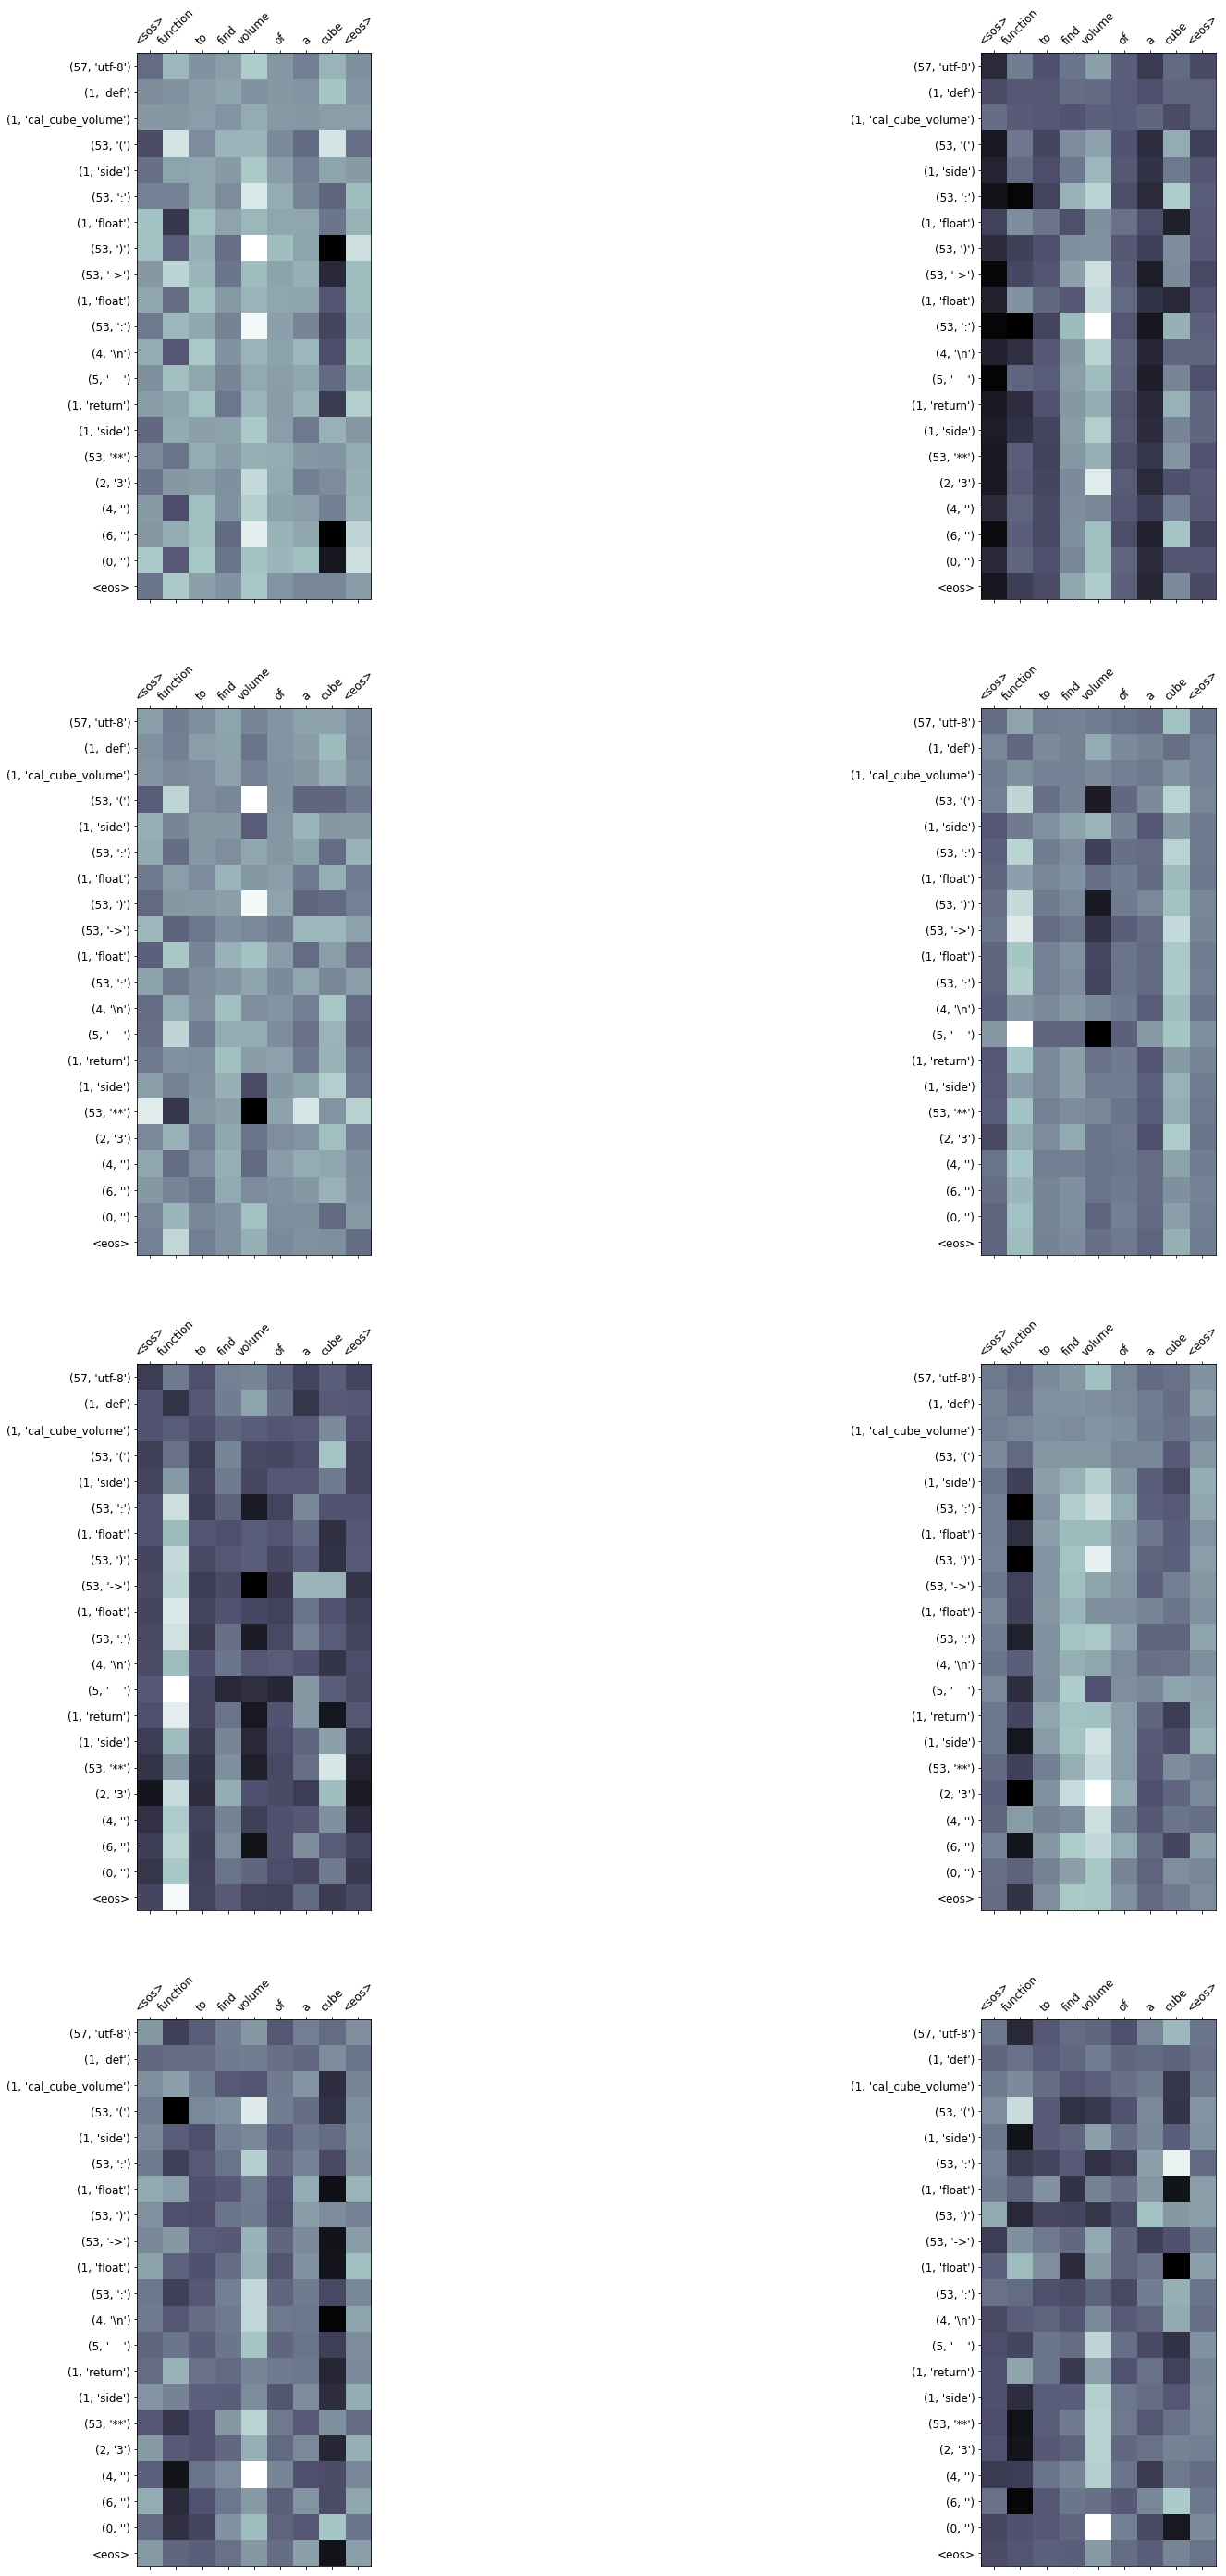

In [67]:
display_attention(src, translation, attention)

## Let's check some sample outputs for Comment to Code translation.


In [67]:
src = "function to merge two lists"
_, _ = comment_to_code(src)

Comment: 
function to merge two lists

Code: 
def merge_lists (l1 :list ,l2 :list ):
    return list (zip (l1 ,l2 ))


In [68]:
src = "function to sum odd elements of list"
_, _ = comment_to_code(src)

Comment: 
function to sum odd elements of list

Code: 
def sum_odd_elements (l :list ):
    return sum ([i for i in l if i %2 ==1 ])


In [69]:
src = "function to find reverse of a string"
_, _ = comment_to_code(src)

Comment: 
function to find reverse of a string

Code: 

def revStr (inp ):
  inp =inp [:::-1 ]
  return inp 


In [70]:
src = "function to find fibonacci sequence"
_, _ = comment_to_code(src)

Comment: 
function to find fibonacci sequence

Code: 

def Fibonacci (n ):
    if n <0 :
        print ("Incorrect input")
        # First Fibonacci number is 0 
    elif n ==0 :
        return 0 
        # Second Fibonacci number is 1 
    elif n ==1 :
        return 1 
    else :
        return Fibonacci (n -1 )+Fibonacci (n -2 )



In [72]:
src = "write a python program to merge two dictionaries"
_, _ = comment_to_code(src)

Comment: 
write a python program to merge two dictionaries

Code: 
x ={'key1':'val1','key2':'val2'}
y ={'key3':'val3','key4':'val4'}
z ={**x ,**y }# z = x | y  


## Gradio App

In [112]:
def predict(src):
    srcs=src.split(" ")
    translation, _ = translate_sentence(srcs, Input, Output, model, device)
    return f"""Code: {untokenize(translation[:-1]).decode('utf-8')}"""

In [ ]:
face = gr.Interface(fn=predict, 
                    inputs=[gr.inputs.Textbox()],
                    title = "Python Comment to Code Generator",
                    description = "Generate Python Code",
                    outputs=["text"])
face.launch(debug=False)

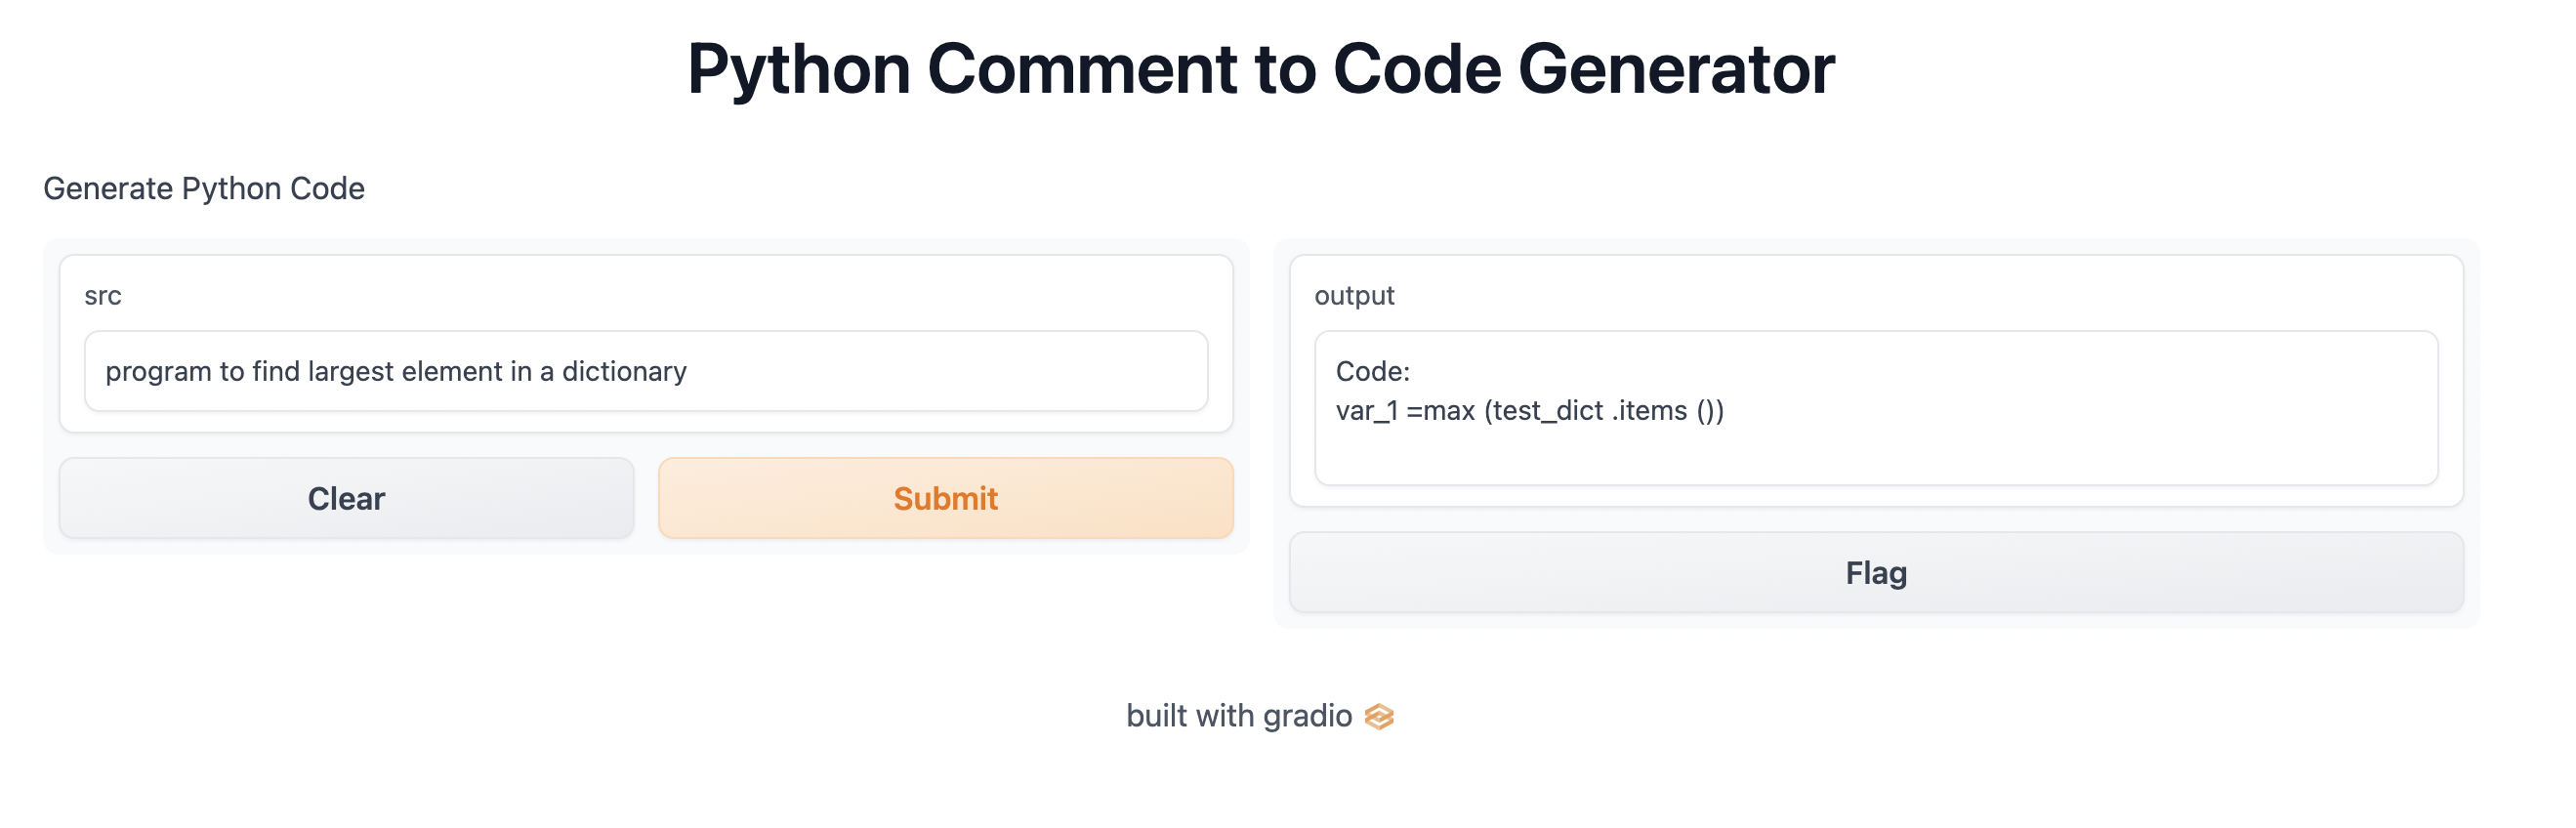